# LSTM-based Electrical Power Consumption Prediction

## 1. Introduction

This notebook handles the entire LSTM model training and evaluation pipeline for our electricity consumption dataset, including:

- **Data Loading**: Importing the preprocessed training, validation, and test datasets

- **Data Preparation**: Standardizing numerical variables using Min-Max scaling to ensure all features are on the same scale

- **Sequence Construction**: Creating fixed-length input time sequences (SEQ_LEN = 24) from the data, each associated with the next target value to be predicted

- **Dataset Creation**: Building TensorFlow datasets with batching and prefetching for efficient model training

- **LSTM Model Development**: Designing and training multiple LSTM models with different architectures to predict electricity consumption:
  - Model 1: Basic LSTM architecture with two stacked LSTM layers
  - Model 2: LSTM architecture with added dropout layer for regularization
  - Model 3: Enhanced LSTM architecture with increased units in both LSTM layers
  - Model 4: LSTM model with longer sequence length (SEQ_LEN = 168) to capture more temporal dependencies

- **Model Evaluation**: Assessing model performance using multiple metrics (MAE, RMSE, MAPE, SMAPE) and visualizing predictions against actual values

- **Error Analysis**: Analyzing prediction errors during atypical periods (weekends, holidays, school breaks) to understand model limitations

- **Model Comparison**: Comparing the performance of different LSTM architectures to identify the most effective model

- **Final Testing**: Evaluating the best-performing model on the test set to assess its generalization capability

The notebook provides a comprehensive approach to developing and evaluating LSTM models for time series forecasting of electricity consumption.

## 2. Data Loading

In [1]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
from dash import Dash, dcc, html
from dash.dependencies import Input as DashInput, Output as DashOutput
import dash
import threading
import time
from IPython.display import display, clear_output
from IPython.display import display
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, DateFormatter,HourLocator, ConciseDateFormatter
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam

In [2]:
# Sets random seeds to ensure result reproducibility (Python, NumPy, TensorFlow, hashing)
os.environ['PYTHONHASHSEED'] = '42'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## Load split data

In [3]:
train_df = pd.read_csv('data/train_df.csv')
val_df = pd.read_csv('data/val_df.csv')
test_df = pd.read_csv('data/test_df.csv')

In [4]:
for df in [train_df, val_df, test_df]:
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)

## 3. Data Preparation

### Standardization of numerical variables

We proceed with the standardization of numerical variables using Min-Max scaling.

In [5]:
print(train_df.dtypes)

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
Hour                       int64
DayOfWeek                  int64
IsWeekend                  int64
dtype: object


In [6]:
# Separation of target variable and features
features_cols = [col for col in train_df.columns if col != 'Global_active_power']
target_col = 'Global_active_power'

# Initialize scalers
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit-transform only on the training data
X_train_scaled = scaler_X.fit_transform(train_df[features_cols])
y_train_scaled = scaler_y.fit_transform(train_df[[target_col]])

# Transform on validation and test sets
X_val_scaled = scaler_X.transform(val_df[features_cols])
y_val_scaled = scaler_y.transform(val_df[[target_col]])

X_test_scaled = scaler_X.transform(test_df[features_cols])
y_test_scaled = scaler_y.transform(test_df[[target_col]])

In [7]:
train_scaled = pd.DataFrame(X_train_scaled, columns=features_cols, index=train_df.index)
train_scaled[target_col] = y_train_scaled

val_scaled = pd.DataFrame(X_val_scaled, columns=features_cols, index=val_df.index)
val_scaled[target_col] = y_val_scaled

test_scaled = pd.DataFrame(X_test_scaled, columns=features_cols, index=test_df.index)
test_scaled[target_col] = y_test_scaled

## 4. Sequence Construction

We create fixed-length input time sequences (SEQ_LEN = 24) from the data, each associated with the next target value to be predicted, in order to prepare the data for an LSTM model performing one-step-ahead prediction.

In [8]:
SEQ_LEN = 24

In [9]:
def create_sequences(df, target_col, seq_len):
    """
    Creates input sequences (X) and corresponding labels (y) from a DataFrame for time series forecasting.

    Args:
        df (pandas.DataFrame): DataFrame containing the time series data with features and target.
        target_col (str): Name of the target column to predict.
        seq_len (int): Length of each sequence (number of time steps).

    Returns:
        X (numpy.ndarray): Array of input sequences with shape (num_sequences, seq_len, num_features).
        y (numpy.ndarray): Array of target values corresponding to each sequence with shape (num_sequences,).
    """
    X, y = [], []
    data_values = df.values
    target_idx = df.columns.get_loc(target_col)
    
    for i in range(len(df) - seq_len):
        seq_x = data_values[i:i+seq_len]  
        seq_y = data_values[i + seq_len, target_idx]  
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

We create sequences separately for each set (train, validation, test) to prevent data leakage.

In [10]:
X_train_scaled, y_train_scaled = create_sequences(train_scaled, 'Global_active_power', SEQ_LEN)
X_val_scaled, y_val_scaled = create_sequences(val_scaled, 'Global_active_power', SEQ_LEN)
X_test_scaled, y_test_scaled = create_sequences(test_scaled, 'Global_active_power', SEQ_LEN)
X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape

((18306, 24, 10), (2013, 24, 10), (5068, 24, 10))

We obtain 18,306 training sequences, 2,013 validation sequences, and 5,068 test sequences, each with a length of 24 time steps and containing 10 variables.

## 5. Dataset Creation

We create the training, validation, and test datasets with TensorFlow by splitting the data into batches of 64 examples (BATCH_SIZE = 64)

In [11]:
BATCH_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_scaled))
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val_scaled))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_scaled))
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
for X_batch, y_batch in train_dataset.take(1):
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)

X_batch shape: (32, 24, 10)
y_batch shape: (32,)


Each input batch of the training set contains 64 sequences, each with a length of 24 time steps (hours), with 10 variables at each time step. Each target batch contains 64 values, one target value (1 variable) per input sequence.

## 6.  LSTM Model Development

## Model 1 

We define a sequential LSTM model consisting of two stacked LSTM layers and a final dense layer that predicts a continuous value. The model is compiled with the Adam optimizer (learning rate set to 0.001), a mean squared error (mse) loss function, and mean absolute error (mae) as the evaluation metric.

In [13]:
num_features = X_train_scaled.shape[2]

model = Sequential([
    Input(shape=(SEQ_LEN, num_features)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)  # Set learning rate here
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

We train the model for 50 epochs using the training and validation sets. Two callbacks are used: EarlyStopping stops training if the validation loss doesn't improve for 10 consecutive epochs (patience), restoring the best weights obtained; ModelCheckpoint saves only the weights corresponding to the best performance on the validation set (minimum val_loss).

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model1.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop, checkpoint],
    shuffle=False
)

Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - loss: 0.0194 - mae: 0.1056 - val_loss: 0.0085 - val_mae: 0.0712
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 0.0108 - mae: 0.0762 - val_loss: 0.0079 - val_mae: 0.0674
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0097 - mae: 0.0712 - val_loss: 0.0075 - val_mae: 0.0651
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.0090 - mae: 0.0677 - val_loss: 0.0070 - val_mae: 0.0613
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0085 - mae: 0.0644 - val_loss: 0.0067 - val_mae: 0.0592
Epoch 6/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.0083 - mae: 0.0630 - val_loss: 0.0065 - val_mae: 0.0579
Epoch 7/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0081 - mae: 0.0621 - val_loss: 0.0065 - val_mae: 0.0572
Epoch 8/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - loss: 0.0080 - mae: 0.0615 - val_loss: 0.0064 - val_mae: 0.0565
Epoch 9/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 

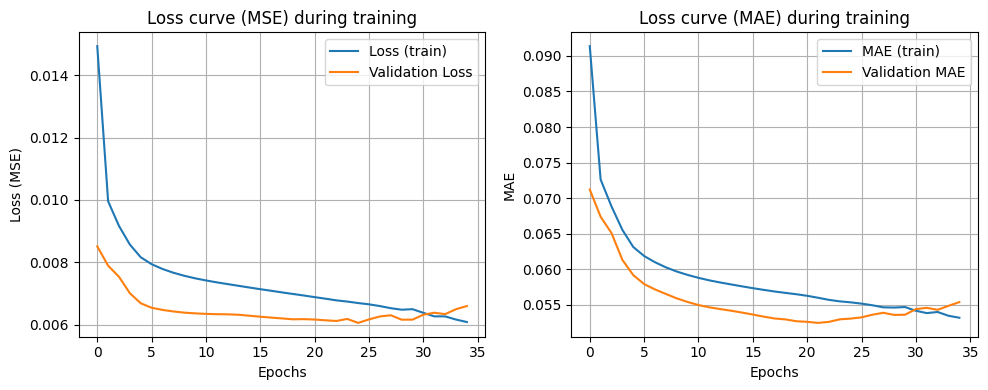

In [15]:
# Display of the loss (Loss) and mean absolute error (MAE) curves during training
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss curve (MSE) during training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE (train)')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Loss curve (MAE) during training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
# Evaluation on the validation set
best_model = tf.keras.models.load_model('best_lstm_model1.keras')
y_pred_scaled = best_model.predict(val_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [17]:
# Function for evaluating the metrics MAE, RMSE, MAPE, and SMAPE
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape
    }

We reconvert the validation values (y_val_scaled) and the predictions (y_pred_scaled) to their original scale using the inverse of the previously applied scaler. Then, we calculate the evaluation metrics between the true values and the predictions.

In [18]:
y_val = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

metrics1 = compute_metrics(y_val, y_pred)

for k, v in metrics1.items():
    print(f"{k}: {v:.4f}")

MAE: 0.3416
RMSE: 0.5011
MAPE: 38.4789
SMAPE: 31.7924


#### Comparison of actual and predicted values over a 2-week window (24h × 14 days)

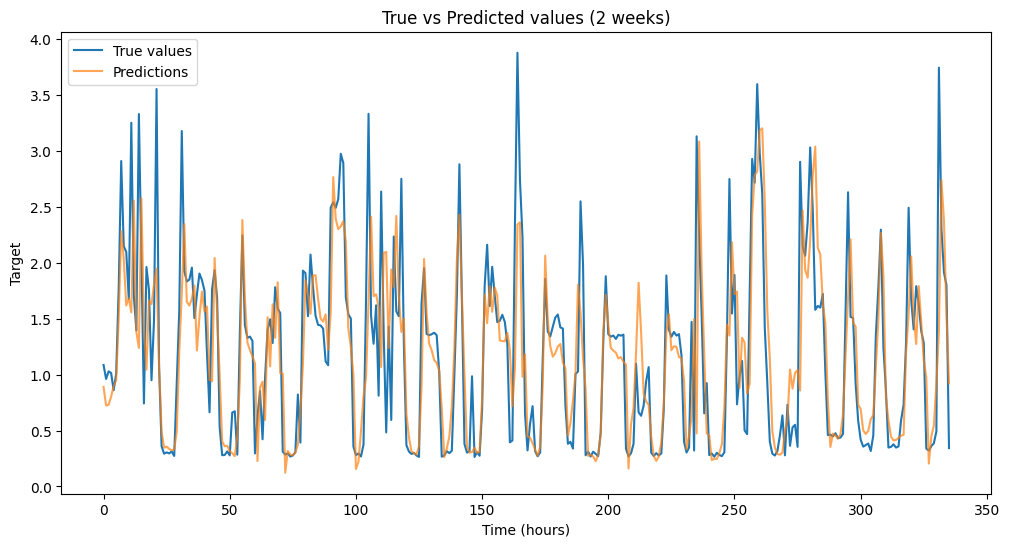

In [19]:
window = 24 * 14
start_idx = 0

# Extract the true value and the prediction from the window
true_window = y_val[start_idx:start_idx+window].flatten()
pred_window = y_pred[start_idx:start_idx+window].flatten()

plt.figure(figsize=(12,6))
plt.plot(true_window, label='True values')
plt.plot(pred_window, label='Predictions', alpha=0.7)
plt.title('True vs Predicted values (2 weeks)')
plt.xlabel('Time (hours)')
plt.ylabel('Target')
plt.legend()
plt.show()

The LSTM model successfully captures the overall trend and daily seasonality of the actual energy consumption values, but struggles to predict the exact amplitude of peaks and troughs, resulting in smoothing of the most extreme fluctuations.

### Model 2

We add a dropout layer after the first LSTM layer to regularize the network and reduce overfitting of the model.

In [20]:
model = Sequential([
    Input(shape=(SEQ_LEN, num_features)),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model2.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop, checkpoint],
    shuffle=False
)

Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.0209 - mae: 0.1101 - val_loss: 0.0087 - val_mae: 0.0715
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - loss: 0.0119 - mae: 0.0806 - val_loss: 0.0081 - val_mae: 0.0682
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - loss: 0.0104 - mae: 0.0746 - val_loss: 0.0077 - val_mae: 0.0657
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.0098 - mae: 0.0716 - val_loss: 0.0073 - val_mae: 0.0633
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 0.0093 - mae: 0.0686 - val_loss: 0.0072 - val_mae: 0.0623
Epoch 6/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 22s 23ms/step - loss: 0.0089 - mae: 0.0667 - val_loss: 0.0071 - val_mae: 0.0609
Epoch 7/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - loss: 0.0087 - mae: 0.0653 - val_loss: 0.0069 - val_mae: 0.0599
Epoch 8/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 0.0086 - mae: 0.0647 - val_loss: 0.0068 - val_mae: 0.0589
Epoch 9/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 

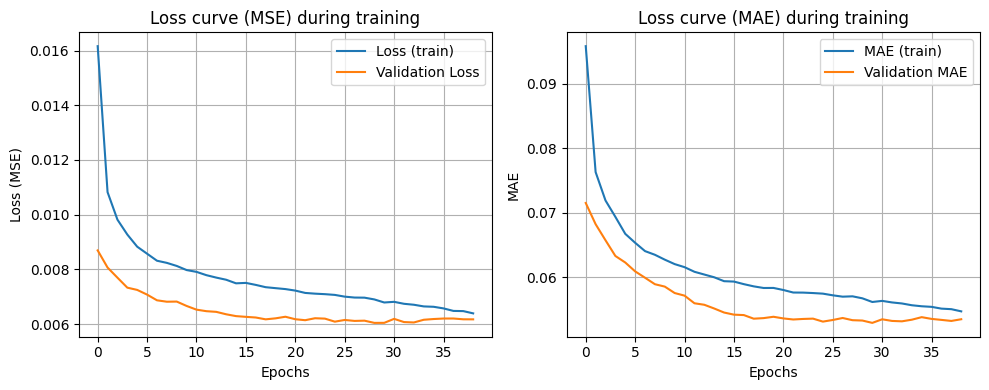

In [22]:
# Display of the loss (Loss) and mean absolute error (MAE) curves during training
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss curve (MSE) during training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE (train)')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Loss curve (MAE) during training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [23]:
# Evaluation on the validation set
best_model = tf.keras.models.load_model('best_lstm_model2.keras')
y_pred_scaled = best_model.predict(val_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [24]:
y_val = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

metrics2 = compute_metrics(y_val, y_pred)

for k, v in metrics2.items():
    print(f"{k}: {v:.4f}")

MAE: 0.3429
RMSE: 0.5003
MAPE: 37.4596
SMAPE: 32.3260


#### Comparison of actual and predicted values over a 2-week window (24h × 14 days)

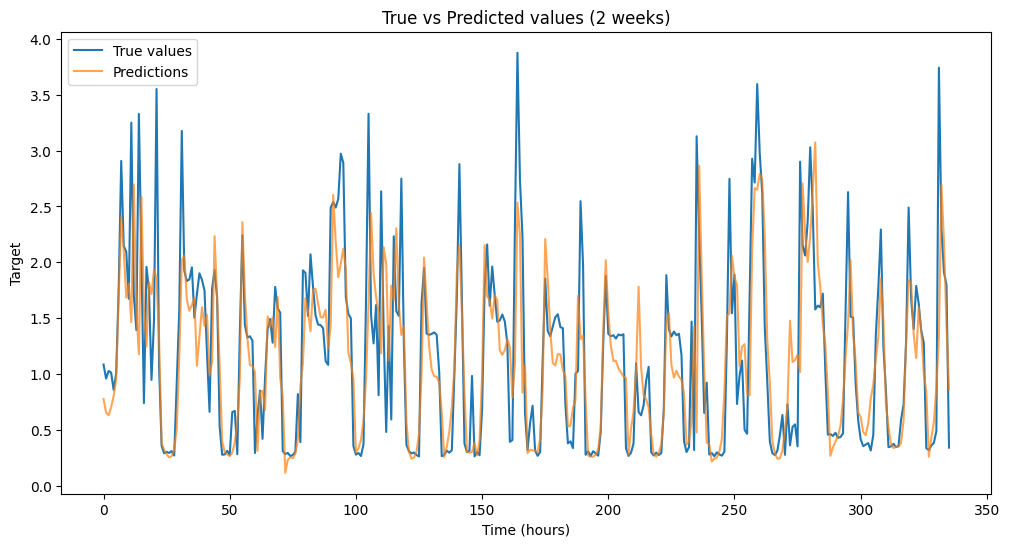

In [25]:
window = 24 * 14
start_idx = 0

# Extract the true value and the prediction from the window
true_window = y_val[start_idx:start_idx+window].flatten()
pred_window = y_pred[start_idx:start_idx+window].flatten()

plt.figure(figsize=(12,6))
plt.plot(true_window, label='True values')
plt.plot(pred_window, label='Predictions', alpha=0.7)
plt.title('True vs Predicted values (2 weeks)')
plt.xlabel('Time (hours)')
plt.ylabel('Target')
plt.legend()
plt.show()

### Model 3

We increase the number of units in both LSTM layers to 128 for the first and 64 for the second, which allows the model to learn better and capture temporal dependencies more effectively.

In [26]:
model = Sequential([
    Input(shape=(SEQ_LEN, num_features)),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)  # Set learning rate here
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [27]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model3.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stop, checkpoint],
    shuffle=False
)

Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step - loss: 0.0200 - mae: 0.1081 - val_loss: 0.0084 - val_mae: 0.0696
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0112 - mae: 0.0773 - val_loss: 0.0079 - val_mae: 0.0666
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 0.0098 - mae: 0.0711 - val_loss: 0.0074 - val_mae: 0.0632
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 0.0091 - mae: 0.0680 - val_loss: 0.0072 - val_mae: 0.0621
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - loss: 0.0088 - mae: 0.0661 - val_loss: 0.0071 - val_mae: 0.0611
Epoch 6/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 0.0086 - mae: 0.0650 - val_loss: 0.0070 - val_mae: 0.0599
Epoch 7/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - loss: 0.0085 - mae: 0.0645 - val_loss: 0.0069 - val_mae: 0.0599
Epoch 8/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 0.0084 - mae: 0.0636 - val_loss: 0.0068 - val_mae: 0.0588
Epoch 9/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 

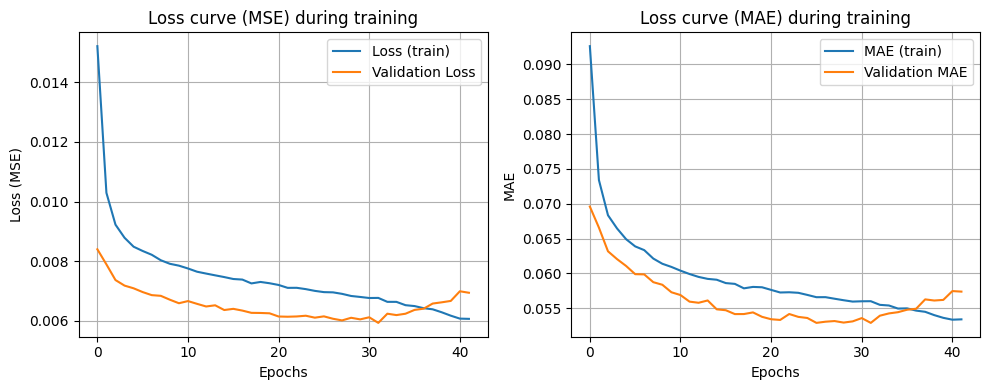

In [28]:
# Display of the loss (Loss) and mean absolute error (MAE) curves during training
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss curve (MSE) during training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE (train)')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Loss curve (MAE) during training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
# Evaluation on the validation set
best_model = tf.keras.models.load_model('best_lstm_model3.keras')
y_pred_scaled = best_model.predict(val_dataset)

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


In [30]:
y_val = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

metrics3 = compute_metrics(y_val, y_pred)

for k, v in metrics3.items():
    print(f"{k}: {v:.4f}")

MAE: 0.3405
RMSE: 0.4956
MAPE: 38.8239
SMAPE: 31.7091


#### Comparison of actual and predicted values over a 2-week window (24h × 14 days)

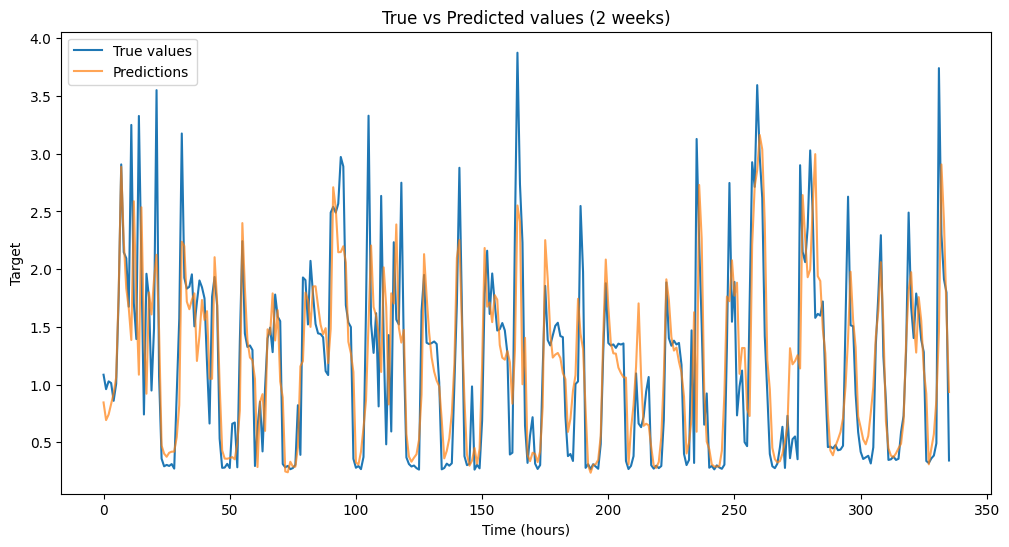

In [31]:
window = 24 * 14
start_idx = 0

# Extract the true value and the prediction from the window
true_window = y_val[start_idx:start_idx+window].flatten()
pred_window = y_pred[start_idx:start_idx+window].flatten()

plt.figure(figsize=(12,6))
plt.plot(true_window, label='True values')
plt.plot(pred_window, label='Predictions', alpha=0.7)
plt.title('True vs Predicted values (2 weeks)')
plt.xlabel('Time (hours)')
plt.ylabel('Target')
plt.legend()
plt.show()

### Model 4

We increase the length of the time sequences (SEQ_LEN = 168) to provide the model with more historical context (a full week of hourly observations), which can improve its ability to capture weekly seasonal patterns and long-term dependencies in the data.

In [32]:
SEQ_LEN = 168

In [33]:
X_train_scaled_long, y_train_scaled_long = create_sequences(train_scaled, 'Global_active_power', SEQ_LEN)
X_val_scaled_long, y_val_scaled_long = create_sequences(val_scaled, 'Global_active_power', SEQ_LEN)
X_test_scaled_long, y_test_scaled_long = create_sequences(test_scaled, 'Global_active_power', SEQ_LEN)
X_train_scaled_long.shape, X_val_scaled_long.shape, X_test_scaled_long.shape

((18162, 168, 10), (1869, 168, 10), (4924, 168, 10))

We obtain 18,162 training sequences, 1,869 validation sequences, and 4,924 test sequences, each with a length of 168 time steps and containing 10 variables.

#### Creation of training, validation, and test datasets

We create the training, validation, and test datasets with TensorFlow by splitting the data into batches of 64 examples (BATCH_SIZE = 64)

In [34]:
BATCH_SIZE = 64

train_dataset_long = tf.data.Dataset.from_tensor_slices((X_train_scaled_long, y_train_scaled_long))
train_dataset_long = train_dataset_long.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset_long = tf.data.Dataset.from_tensor_slices((X_val_scaled_long, y_val_scaled_long))
val_dataset_long = val_dataset_long.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset_long = tf.data.Dataset.from_tensor_slices((X_test_scaled_long, y_test_scaled_long))
test_dataset_long = test_dataset_long.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [35]:
for X_batch, y_batch in train_dataset_long.take(1):
    print("X_batch shape:", X_batch.shape)
    print("y_batch shape:", y_batch.shape)

X_batch shape: (64, 168, 10)
y_batch shape: (64,)


Each input batch of the training set contains 64 sequences, each with a length of 168 time steps (hours), with 10 variables at each time step. Each target batch contains 64 values, one target value (1 variable) per input sequence.

#### LSTM Modeling and Training

In [36]:
model = Sequential([
    Input(shape=(SEQ_LEN, num_features)),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)  # Set learning rate here
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_lstm_model4.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_dataset_long,
    validation_data=val_dataset_long,
    epochs=50,
    callbacks=[early_stop, checkpoint],
    shuffle=False
)

Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 111s 376ms/step - loss: 0.0248 - mae: 0.1194 - val_loss: 0.0099 - val_mae: 0.0725
Epoch 2/50
184/284 ━━━━━━━━━━━━━━━━━━━━ 34s 346ms/step - loss: 0.0143 - mae: 0.0885

In [ ]:
# Display of the loss (Loss) and mean absolute error (MAE) curves during training
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (train)')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss curve (MSE) during training')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='MAE (train)')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Loss curve (MAE) during training')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Evaluation on the validation set
best_model = tf.keras.models.load_model('best_lstm_model4.keras')
y_pred_scaled_long = best_model.predict(val_dataset_long)

In [ ]:
y_val = scaler_y.inverse_transform(y_val_scaled_long.reshape(-1, 1)).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled_long.reshape(-1, 1)).flatten()

metrics4 = compute_metrics(y_val, y_pred)

for k, v in metrics4.items():
    print(f"{k}: {v:.4f}")

#### Comparison of actual and predicted values over a 2-week window (24h × 14 days)

In [ ]:
window = 24 * 14
start_idx = 0

# Extract the true value and the prediction from the window
true_window = y_val[start_idx:start_idx+window].flatten()
pred_window = y_pred[start_idx:start_idx+window].flatten()

plt.figure(figsize=(12,6))
plt.plot(true_window, label='True values')
plt.plot(pred_window, label='Predictions', alpha=0.7)
plt.title('True vs Predicted values (2 weeks)')
plt.xlabel('Time (hours)')
plt.ylabel('Target')
plt.legend()
plt.show()

## 7. Model Comparison

In [ ]:
df = pd.DataFrame([metrics1, metrics2, metrics3, metrics4], index=['Model 1', 'Model 2', 'Model 3', 'Model 4'])
df

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# First subplot: MAE & RMSE
df[['MAE', 'RMSE']].T.plot(kind='bar', ax=axes[0])
axes[0].set_title('MAE et RMSE')
axes[0].set_xlabel('Metrics')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend(title='Models')
axes[0].tick_params(axis='x', rotation=0)

# Adding labels to bars
for bars in axes[0].patches:
    height = bars.get_height()
    axes[0].text(
        bars.get_x() + bars.get_width() / 2,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=90
    )
axes[0].set_ylim(0,0.6)

# Second subplot: MAPE & SMAPE
df[['MAPE', 'SMAPE']].T.plot(kind='bar', ax=axes[1])
axes[1].set_title('MAPE et SMAPE')
axes[1].set_ylabel('Value (%)')
axes[1].set_xlabel('Metrics')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
axes[1].legend(title='Models')
axes[1].tick_params(axis='x', rotation=0)

# Adding labels to bars
for bars in axes[1].patches:
    height = bars.get_height()
    axes[1].text(
        bars.get_x() + bars.get_width() / 2,
        height,
        f'{height:.3f}',
        ha='center',
        va='bottom',
        fontsize=9,
        rotation=90
    )
axes[1].set_ylim(0,50)

plt.tight_layout()
plt.show()

For the error metrics (MAE, RMSE, MAPE, SMAPE) where lower is better, Model 3 is the most performant overall, showing the lowest SMAPE, RMSE, and MAE, and being competitive on MAPE.

## 8. Final Testing

Evaluating the best-performing model on the test set to assess its generalization capability

In [ ]:
best_model = tf.keras.models.load_model('best_lstm_model3.keras')
y_pred_scaled = best_model.predict(test_dataset)
y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

In [ ]:
print(y_test_scaled.shape, y_pred_scaled.shape)

In [ ]:
y_test = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

metrics4 = compute_metrics(y_test, y_pred)
print(y_test.shape, y_pred.shape)

for k, v in metrics4.items():
    print(f"{k}: {v:.4f}")

In [ ]:
window = 24 * 14
start_idx = 0

# Extract the true value and the prediction from the window
true_window = y_test[start_idx:start_idx+window].flatten()
pred_window = y_pred[start_idx:start_idx+window].flatten()

plt.figure(figsize=(12,6))
plt.plot(true_window, label='True values')
plt.plot(pred_window, label='Predictions', alpha=0.7)
plt.title('True vs Predicted values (2 weeks)')
plt.xlabel('Time (hours)')
plt.ylabel('Target')
plt.legend()
plt.show()

#### Error Analysis

In [ ]:
SEQ_LEN = 24

# Index of predictions
dates_test = test_df.index[SEQ_LEN : train_df.shape[0]]

# Calculation of absolute errors
abs_errors = np.abs(y_test - y_pred)

errors_df = pd.DataFrame({
    'Date': dates_test,
    'Absolute Error': abs_errors.flatten()
})
errors_df.set_index('Date', inplace=True)

# Define school holidays Zone C (Paris/Sceaux) - Academic year 2008-2009
holidays_zone_c_2009 = [
    ("2009-07-04", "2009-09-01"),  # Été
]

# Public holidays 2009 in France
public_holidays_2009 = [
    "2009-06-01",  # Whit Monday
    "2009-07-14",  # Bastille Day
    "2009-08-15",  # Assumption Day
    "2009-11-01",  # All Saints' Day
    "2009-11-11",  # Armistice Day
    "2009-12-25",  # Christmas
]
public_holidays_2009 = [pd.to_datetime(d) for d in public_holidays_2009]

plt.figure(figsize=(10, 6))
plt.plot(errors_df.index, errors_df['Absolute Error'], label="Absolute Error", color='orange')

# Add school holiday zones, weekends, and public holidays
for start, stop in holidays_zone_c_2009:
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(stop), color='red', alpha=0.2, label='School holidays')

for f in public_holidays_2009:
    if f in errors_df.index:
        plt.axvline(f, color='blue', linestyle='--', alpha=0.8, label='Public holiday')

for date in errors_df.index:
    if date.weekday() >= 5:  # 5 = saturday, 6 = sunday
        plt.axvspan(date, date + pd.Timedelta(hours=1), color='gray', alpha=0.1, label='Week-end')

# Cleaning duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.title("Absolute error of LSTM predictions on the test set - Year 2009")
plt.xlabel("Date")
plt.ylabel("Absolute error (kW)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# DataFrame with absolute errors and dates
errors_df = pd.DataFrame({
    'Date': dates_test,
    'y_true': y_test.flatten(),
    'y_pred': y_pred.flatten()
})
errors_df['Absolute Error'] = np.abs(errors_df['y_true'] - errors_df['y_pred'])

# Extract the day of the week (0 = Monday, 6 = Sunday)
errors_df['Weekday'] = errors_df['Date'].dt.dayofweek

# Calculate and display the mean absolute error (MAE) by day of the week
mae_by_weekday = errors_df.groupby('Weekday')['Absolute Error'].mean()

weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(8, 5))
plt.bar(weekday_labels, mae_by_weekday)
plt.title("Average absolute error by weekday on the test set")
plt.ylabel("MAE")
plt.xlabel("Day of the week")
plt.tight_layout()
plt.show()

The relatively high errors of the model, particularly the MAPE and SMAPE, are explained by the irregularity of domestic electricity consumption, influenced by weekends, school holidays, and the unpredictable behavior of occupants. This variability is highlighted by the graphs of absolute errors and average errors by day of the week. These atypical periods, often underrepresented in the training data, generate fluctuations that are difficult to model, affecting the accuracy of the predictions.